
Procedo a analizar la relacion entre el codigo burocratico y si la operacion
es exitosa o no en base al porcentaje de closed Won sobre closed Lost.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('Entrenamieto_ECI_2020.csv').drop_duplicates(subset=['Opportunity_ID'])
#No cuento opportunities repetidos, el resultado igual es por opportunity
#y no por producto asi que no es que pierdo resultados

data.replace(to_replace=['Delivery_Terms_0', 'Delivery_Terms_1', 'Delivery_Terms_2',
                                     'Delivery_Terms_3', 'Delivery_Terms_4',
                                     'Delivery_Terms_5', 'Delivery_Terms_6',
                         'Delivery_Terms_7', 'Delivery_Terms_8'],
                         value=['0', '1', '2', '3', '4', '5', '6', '7', '8'], inplace=True)

deliveryTerms = data[['Delivery_Terms', 'Stage']]

deliveryTerms = deliveryTerms[deliveryTerms['Stage'].isin(values=['Closed Won', 'Closed Lost'])]

deliveryTerms.replace(to_replace=['Closed Won', 'Closed Lost'], value=[1, 0], inplace=True)

Analizo cuantos datos tengo de cada Delivery Terms para ver cuales considero
estadisticamente suficientes

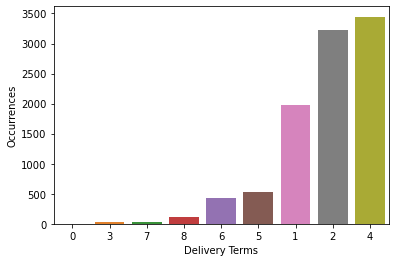

In [2]:
termsCount = deliveryTerms['Delivery_Terms'].value_counts().to_frame().reset_index().sort_values('Delivery_Terms')

sns.barplot(x='Delivery Terms', y='Occurrences', data=(termsCount.rename(columns=
            {'index':'Delivery Terms', 'Delivery_Terms':'Occurrences'})), order=termsCount['index'])

plt.savefig('img/DeliveryTerms/DTermsOccurrences.png')

Cambiando la escala para ver los Codes con menores ocurrencias

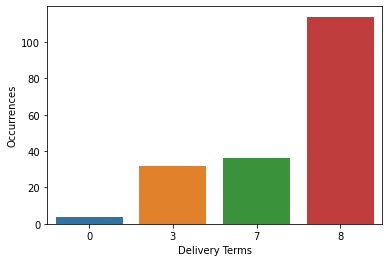

In [3]:
termsCount = termsCount[termsCount['index'].isin(['0', '3', '7', '8'])]
sns.barplot(x='Delivery Terms', y='Occurrences', data=(termsCount.rename(columns=
            {'index':'Delivery Terms', 'Delivery_Terms':'Occurrences'})),
            order=termsCount['index'])

plt.savefig('img/DeliveryTerms/DTermsFiltered.png')

Como para los delivery terms 0, 3, y 7 tenemos menos de 40 datos no los tomaremos en cuenta
para el analisis, quedandonos entonces solo con los codigos 1, 2, 4, 5, 6, 7 y 8

Tenemos entonces que el rate de oportunidades ganadas para las oportunidades con estos
delivery terms es

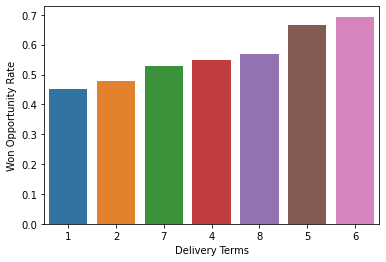

In [4]:
validStatisticalTerms = ['1', '2', '4', '5', '6', '7', '8']

wonOpportunityRate = deliveryTerms[(deliveryTerms['Delivery_Terms'].isin(validStatisticalTerms))]\
                    .groupby('Delivery_Terms').agg({'Stage':'mean'}).reset_index().sort_values('Stage')

wonOpportunityRate.rename(columns={'Delivery_Terms':'Delivery Terms', 'Stage':'Won Opportunity Rate'}, inplace=True)

sns.barplot(x='Delivery Terms', y='Won Opportunity Rate', data=wonOpportunityRate,
            order=wonOpportunityRate['Delivery Terms'])

plt.savefig('img/DeliveryTerms/DTermsWonRate.png')

Ahora analizo si algunos delivery terms suelen necesitar ser aprobados mas que otros,
y ademas analizo que tanto mas aprobados son.

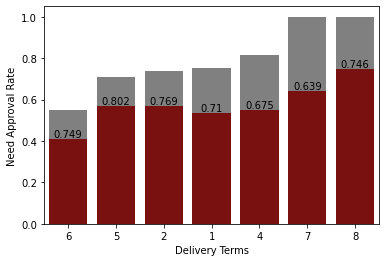

In [5]:
termsApprovals = data[['Delivery_Terms', 'Pricing, Delivery_Terms_Quote_Appr', 'Pricing, Delivery_Terms_Approved']]

termsApprovals = termsApprovals[termsApprovals['Delivery_Terms'].isin(validStatisticalTerms)]

termsApprovals = termsApprovals.groupby('Delivery_Terms').agg({'Pricing, Delivery_Terms_Quote_Appr':['mean', 'sum'],
                                       'Pricing, Delivery_Terms_Approved':'sum'})

termsApprovals[('','Approved Rate')] = termsApprovals[('Pricing, Delivery_Terms_Approved', 'sum')]  /\
                                         termsApprovals[('Pricing, Delivery_Terms_Quote_Appr', 'sum')]

termsApprovals.drop(['Pricing, Delivery_Terms_Approved', ('Pricing, Delivery_Terms_Quote_Appr', 'sum')], axis=1, inplace=True)

termsApprovals = termsApprovals.droplevel(0, axis=1).reset_index().rename(columns={'Delivery_Terms':'Delivery Terms',
                                                                         'mean':'Need Approval Rate'})\
                .sort_values('Need Approval Rate')

#Hago los graficos que muestran en las barras que porcentaje de ese term necesita
#ser aprobado, y en colorcito relleno que porcentaje de esos que necesitaban ser aprobados
#fueron finalmente aprobados

ax = sns.barplot(x='Delivery Terms', y='Need Approval Rate', data=termsApprovals,
           order=termsApprovals['Delivery Terms'], color='grey')

#Reescalo para graficar (o sea, convierto el porcentaje absoluto a porcentaje relativo
#en el grafico para que quede bien el relleno

termsApprovals['Approved Rate'] = termsApprovals['Approved Rate']*termsApprovals['Need Approval Rate']

sns.barplot(x='Delivery Terms', y='Approved Rate', data=termsApprovals,
           order=termsApprovals['Delivery Terms'], color='darkred', ax=ax)

ax.set(ylabel='Need Approval Rate')

i = 0
for index, row in termsApprovals.iterrows():
    ax.text(i, row['Approved Rate'] + 0.01, round(row['Approved Rate']/row['Need Approval Rate'], 3), color='black', ha="center")
    i = i + 1

plt.savefig('img/DeliveryTerms/DTermsApprovalRate.png')